# Fake News Detection

The topic of fake news detection on social media has recently attracted tremendous attention. The basic countermeasure of comparing websites against a list of labeled fake news sources is inflexible, and so a machine learning approach is desirable. Our project aims to use Natural Language Processing to detect fake news directly, based on the text content of news articles.

### Objective

Develop a machine learning program to identify when an article might be fake news.

### Dataset Description:

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks whether the news article is real or fake:
    - Fake news - 1
    - Real News - 0

### Importing Libraries

In [82]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense
# from sklearn.metrics import classification_report,accuracy_score
# from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [83]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [84]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Data Pre-processing

In [85]:
news_data = pd.read_csv('/Projects/Fake News Detection/Datasets/train.csv')
test_data = pd.read_csv('/Projects/Fake News Detection/Datasets/test.csv')
news_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [86]:
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [87]:
news_data.shape

(20800, 5)

In [88]:
test_data.shape

(5200, 4)

In [89]:
news_data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [90]:
test_data.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [91]:
# replacing the null values with empty string
news_data = news_data.fillna('')
test_data = test_data.fillna('')

In [92]:
news_data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [93]:
# merging the author name and news title

news_data['content'] = news_data['author']+' '+news_data['title']
test_data['content'] = test_data['author']+' '+test_data['title']

In [94]:
print(news_data['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [95]:
# separating the data & label

## Get the Independent Features
X = news_data.drop(columns='label', axis=1)
## Get the Dependent features
Y = news_data['label']

In [96]:
Y.value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [97]:
print(X)
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

In [98]:
# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test_data.copy()
messages_test.reset_index(inplace=True)

### Stemming

- A stemming algorithm is a process of linguistic normalisation, in which the variant forms of a word are reduced to a common form.
- In simple words, Stemming is the process of reducing a word to its Root word.

- EXAMPLES:
    - actor, actress, acting --> act
    - eating, eats, eaten --> eat

In [99]:
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['content'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'daniel j flynn flynn hillari clinton big woman campu breitbart'

In [100]:
test_corpus[1]

'russian warship readi strike terrorist near aleppo'

Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size=5000. This is done to obtain numerical feature matrix

In [101]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [102]:
one_hot_test[1]

[76, 4807, 1219, 3078, 3933, 3803, 2722]

Below code creates an embedding layer which applies "pre" padding to the one-hot encoded features with sentence length = 20. Padding is applied so that the length of every sequence in the dataset should be same.

In [103]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train)

[[   0    0    0 ... 1111 4588 1229]
 [   0    0    0 ... 4499  318 1787]
 [   0    0    0 ... 1708 3099  119]
 ...
 [   0    0    0 ... 1467 3639  247]
 [   0    0    0 ... 3520   66 1833]
 [   0    0    0 ... 2907 3289 3355]]


In [104]:
print(embedd_docs_test)

[[   0    0    0 ... 1467 3639  247]
 [   0    0    0 ... 3933 3803 2722]
 [   0    0    0 ... 4877  250 1868]
 ...
 [   0    0    0 ... 1467 3639  247]
 [   0    0    0 ...   76 3168 2189]
 [   0    0    0 ... 1467 3639  247]]


In [105]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(Y)
x_test_final = np.array(embedd_docs_test)

In [106]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((20800, 20), (20800,), (5200, 20))

Dividing the dataset into training,validation and testing data (ratio: 80/10/10) using train_test_split technique.

In [107]:
# SPLITTING THE DATASET INTO TRAINING DATA & TEST DATA:

x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
x_test_final = x_test_final


### Training the Models:


#### Logistic Regression:

Logistic regression is a statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set. A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables.

In [108]:
model = LogisticRegression(max_iter=900)

In [109]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=900)

#### Evaluation

In [110]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [111]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.7708333333333334


In [112]:
# accuracy score on the test data
X_test_prediction = model.predict(x_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [113]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7735576923076923


In [114]:
print(classification_report(Y_test, X_test_prediction))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1039
           1       0.77      0.78      0.77      1041

    accuracy                           0.77      2080
   macro avg       0.77      0.77      0.77      2080
weighted avg       0.77      0.77      0.77      2080



### Confusion Matrix
The confusion matrix is a 2 dimensional array comparing predicted category labels to the true label.

In [115]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### CLASSIFICATION MODEL : MULTINOMIAL NAIVE BAYES

- Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP)

- Multinomial Naïve Bayes uses term frequency i.e. the number of times a given term appears in a document. Term frequency is often normalized by dividing the raw term frequency by the document length


In [116]:
#let's implement the model : Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

accuracy:   0.714
Confusion matrix, without normalization


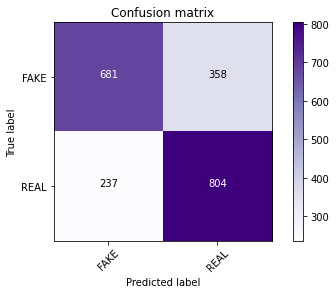

In [117]:
from sklearn import metrics
import numpy as np
import itertools

classifier.fit(X_train, Y_train)
prediction1 = classifier.predict(x_test)
score = metrics.accuracy_score(Y_test, prediction1)
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(Y_test, prediction1)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])
plt.savefig("NaiveBayes_CM")

In [118]:
print(classification_report(Y_test,prediction1))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1039
           1       0.69      0.77      0.73      1041

    accuracy                           0.71      2080
   macro avg       0.72      0.71      0.71      2080
weighted avg       0.72      0.71      0.71      2080



### CLASSIFICATION MODEL : PASSIVE AGGRESSIVE CLASSIFIER

- Passive Aggressive Classifier works by responding as passive for correct classifications and responding as aggressive for any miscalculation.

accuracy:   0.731
Confusion matrix, without normalization


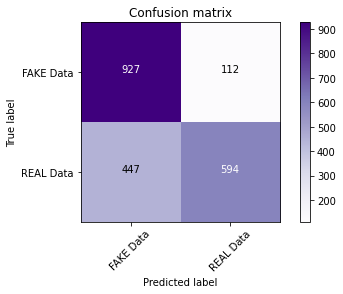

In [119]:
#lets implemet the algorithm : Passive Aggressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)

linear_clf.fit(X_train, Y_train)
prediction2 = linear_clf.predict(x_test)
score = metrics.accuracy_score(Y_test, prediction2)
print("accuracy:   %0.3f" % score)
cm2 = metrics.confusion_matrix(Y_test, prediction2)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])
plt.savefig("PassiveAggressive_CM")

In [120]:
print(classification_report(Y_test,prediction2))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77      1039
           1       0.84      0.57      0.68      1041

    accuracy                           0.73      2080
   macro avg       0.76      0.73      0.72      2080
weighted avg       0.76      0.73      0.72      2080



## Model : Decision Trees

A decision tree is a graph that uses a branching method to illustrate every possible output for a specific input.

Confusion matrix, without normalization


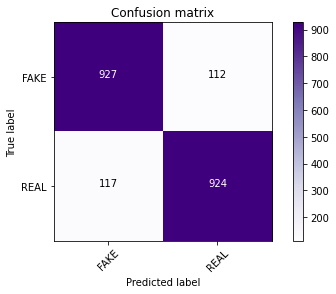

In [121]:
model_4 = DecisionTreeClassifier()
model_4.fit(X_train,Y_train)
prediction3 = model_4.predict(x_test)
cm1 = metrics.confusion_matrix(Y_test, prediction3)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])
plt.savefig("DecisionTrees_CM")

In [122]:
cr3    = classification_report(Y_test,prediction3)
print(cr3)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1039
           1       0.89      0.89      0.89      1041

    accuracy                           0.89      2080
   macro avg       0.89      0.89      0.89      2080
weighted avg       0.89      0.89      0.89      2080



## Model : Random Forest

The random forest is a classification algorithm consisting of many decisions trees.

Confusion matrix, without normalization


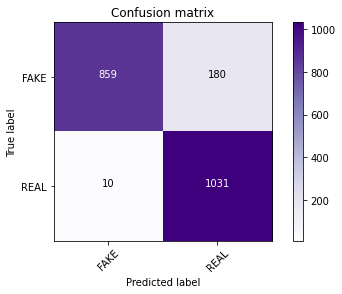

In [123]:
model_5 = RandomForestClassifier()
model_5.fit(X_train,Y_train)
prediction4 = model_5.predict(x_test)
cm1 = metrics.confusion_matrix(Y_test, prediction4)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])
plt.savefig("RandomForest_CM")

In [124]:
cr4    = classification_report(Y_test,prediction4)
print(cr4)

              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1039
           1       0.85      0.99      0.92      1041

    accuracy                           0.91      2080
   macro avg       0.92      0.91      0.91      2080
weighted avg       0.92      0.91      0.91      2080



## XGBOOST

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

Confusion matrix, without normalization


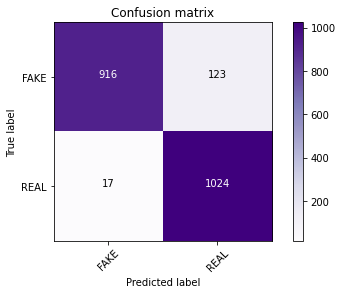

In [125]:
model_6 = XGBClassifier()
model_6.fit(X_train,Y_train)
prediction5 = model_6.predict(x_test)
cm1 = metrics.confusion_matrix(Y_test, prediction5)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])
plt.savefig("XGBoost_CM")

In [126]:
cr5    = classification_report(Y_test,prediction5)
print(cr5)

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1039
           1       0.89      0.98      0.94      1041

    accuracy                           0.93      2080
   macro avg       0.94      0.93      0.93      2080
weighted avg       0.94      0.93      0.93      2080



## LSTM
In this model, 1.) The value for embedding feature vectors = 40 which are target feature vectors for the embedding layer. 2.) Single LSTM Layer with 100 nodes are used. 3.)Dense Layer with 1 neuron and sigmoid activation function is used since, this is a binary classification problem. 4) Dropout technique is used to avoid overfiiting and adam optimizer is used for optimizing the loss function.

In [127]:
# Creating the LSTM Model for prediction
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [128]:
# Training the model
model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

Epoch 1/10
264/264 [==============================] - 7s 22ms/step - loss: 0.2242 - accuracy: 0.9044 - val_loss: 0.0568 - val_accuracy: 0.9834
Epoch 2/10
264/264 [==============================] - 6s 21ms/step - loss: 0.0350 - accuracy: 0.9890 - val_loss: 0.0285 - val_accuracy: 0.9893
Epoch 3/10
264/264 [==============================] - 6s 21ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 0.0242 - val_accuracy: 0.9893
Epoch 4/10
264/264 [==============================] - 6s 21ms/step - loss: 0.0073 - accuracy: 0.9983 - val_loss: 0.0331 - val_accuracy: 0.9899
Epoch 5/10
264/264 [==============================] - 6s 21ms/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.0335 - val_accuracy: 0.9904
Epoch 6/10
264/264 [==============================] - 6s 21ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0260 - val_accuracy: 0.9925
Epoch 7/10
264/264 [==============================] - 5s 21ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0296 - val_accuracy: 0.9904

65/65 [==============================] - 1s 5ms/step
Confusion matrix, without normalization


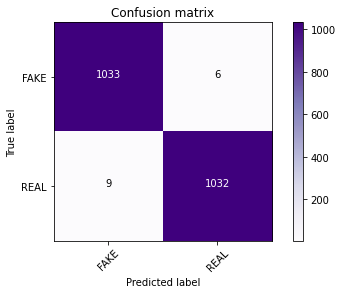

In [129]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
cm1 = metrics.confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])
plt.savefig("LSTM_CM")

In [130]:
cr = classification_report(y_test,predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1039
           1       0.99      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080



# Evaluation of Models

In [131]:
score_1 = accuracy_score(y_test,X_test_prediction)
score_2 = accuracy_score(y_test,prediction1)
score_3 = accuracy_score(y_test,prediction2)
score_4 = accuracy_score(y_test,prediction3)
score_5 = accuracy_score(y_test,prediction4)
score_6 = accuracy_score(y_test,prediction5)
score_7 = accuracy_score(y_test,predictions)
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Passive Aggressive",score_3],["Decision Tree",score_4],
                       ["Random Forest",score_5],["XGBOOST",score_6],["LSTM",score_7]],columns=["Model","Accuracy"])
results

,Model,Accuracy
0,Logistic Regression,0.773558
1,Naive Bayes,0.713942
2,Passive Aggressive,0.731250
3,Decision Tree,0.889904
4,Random Forest,0.908654
5,XGBOOST,0.932692
6,LSTM,0.992788


<b>From the above results, it appears that LSTM Model gives the highest accuracy amongst various models. Therefore, it is selected as the final model for making predictions on final testing data.</b>

### Predictions on Testing Data

In [132]:
# Making Predictions on test data
predictions_test = pd.DataFrame((model.predict(x_test) > 0.5).astype("int32"))
test_id = pd.DataFrame(test_data["id"])

65/65 [==============================] - 0s 6ms/step


In [133]:
predictions_test

,0
0,1
1,1
2,1
3,0
4,0
...,...
2075,1
2076,1
2077,1
2078,0
